<a href="https://colab.research.google.com/github/umersajid11/CatDogClassification/blob/main/catdogclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
 98% 1.04G/1.06G [00:04<00:00, 260MB/s]
100% 1.06G/1.06G [00:04<00:00, 232MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
import os, shutil
from sklearn.model_selection import train_test_split

# Define source folders
base_dir = "/content/train"
cat_dir = os.path.join(base_dir, "cats")
dog_dir = os.path.join(base_dir, "dogs")

# Get image file names
cat_images = [f for f in os.listdir(cat_dir) if f.endswith('.jpg')]
dog_images = [f for f in os.listdir(dog_dir) if f.endswith('.jpg')]

# Split into train and val (90% train, 10% val)
cat_train, cat_val = train_test_split(cat_images, test_size=0.1, random_state=42)
dog_train, dog_val = train_test_split(dog_images, test_size=0.1, random_state=42)

# Create new folder structure
def make_dirs(base_path):
    for subset in ['train', 'val']:
        for label in ['cats', 'dogs']:
            path = os.path.join(base_path, subset, label)
            os.makedirs(path, exist_ok=True)

make_dirs('/content/data')

# Function to move images
def move_images(images, src_folder, dst_folder):
    for img in images:
        src = os.path.join(src_folder, img)
        dst = os.path.join(dst_folder, img)
        shutil.copyfile(src, dst)

# Move cat images
move_images(cat_train, cat_dir, '/content/data/train/cats')
move_images(cat_val, cat_dir, '/content/data/val/cats')

# Move dog images
move_images(dog_train, dog_dir, '/content/data/train/dogs')
move_images(dog_val, dog_dir, '/content/data/val/dogs')


In [ ]:
Data Augmentation

In [6]:
# Preprocessing
image_size = (256, 256)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=40,
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest'
)

In [7]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
#Generator
train_generator = train_datagen.flow_from_directory(
    '/content/data/train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'  # Since it's binary classification: cat vs dog
)

val_generator = val_datagen.flow_from_directory(
    '/content/data/val',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)


Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [9]:
print(train_generator.class_indices)

{'cats': 0, 'dogs': 1}


In [10]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(256,256,3), kernel_regularizer=regularizers.l2(l2=0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))
model.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu', kernel_regularizer=regularizers.l2(l2=0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))
model.add(Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu', kernel_regularizer=regularizers.l2(l2=0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [15]:
history = model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 319s 544ms/step - accuracy: 0.5211 - loss: 5.5851 - val_accuracy: 0.5875 - val_loss: 1.3340
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 291s 518ms/step - accuracy: 0.5547 - loss: 1.2484 - val_accuracy: 0.6085 - val_loss: 0.9074
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 291s 517ms/step - accuracy: 0.5699 - loss: 0.8984 - val_accuracy: 0.6255 - val_loss: 0.7781
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 288s 511ms/step - accuracy: 0.5848 - loss: 0.7930 - val_accuracy: 0.6090 - val_loss: 0.8209
Epoch 5/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 288s 512ms/step - accuracy: 0.5872 - loss: 0.7695 - val_accuracy: 0.5625 - val_loss: 0.7843
Epoch 6/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 287s 510ms/step - accuracy: 0.5560 - loss: 0.7593 - val_accuracy: 0.6000 - val_loss: 0.6915
Epoch 7/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 291s 517ms/step - accuracy: 0.5768 - loss: 0.7074 - val_accuracy: 0.6015 - val_loss: 0.7207
Epoch 8/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 289s 513ms/step - accuracy: 0.5883 -

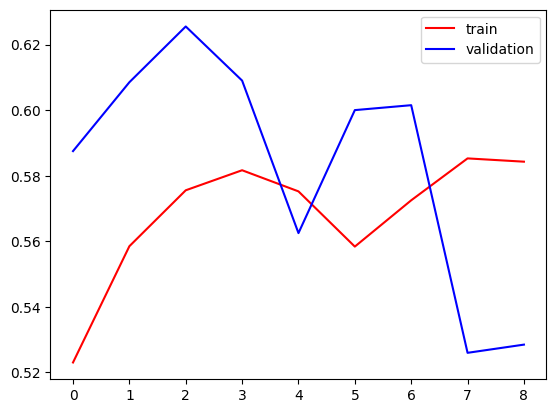

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='validation')
plt.legend()
plt.show()

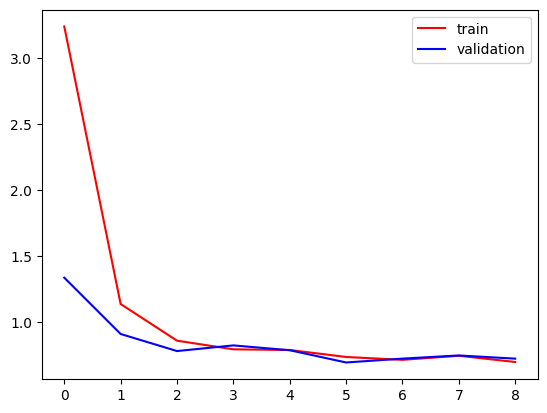

In [17]:
plt.plot(history.history['loss'], color='red', label='train')
plt.plot(history.history['val_loss'], color='blue', label='validation')
plt.legend()
plt.show()

In [ ]:
#Way to Reduce Overfitting
#Add More Data
#Data AUgmentation
#L1/L2 Regulizer
#Dropout
#Batch Norm
#Reduce Complexity